In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Observations

In [14]:
truth = 1.
observations = torch.load("observations.th")

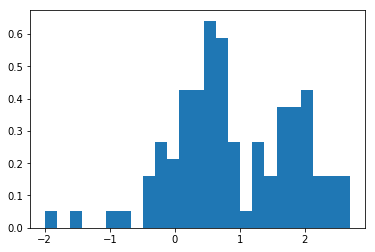

In [16]:
plt.hist(observations.numpy(), density=True, bins=25)
plt.show()

## Utilities

In [49]:
from hypothesis.visualization.mcmc import plot_density
from hypothesis.visualization.mcmc import plot_trace
from hypothesis.visualization.mcmc import plot_autocorrelation

def visualize(result):
    # Density
    plot_density(result, show_mean=True, truth=truth, bins=50)
    plt.show()
    # Trace
    plot_trace(result, show_mean=True, show_burnin=True, truth=truth, aspect=2.)
    plt.show()
    # Autocorrelation
    plot_autocorrelation(result, max_lag=100, interval=1)
    plt.show()

## Classifer

In [50]:
classifier = torch.load("models/1000_final.th")

## Posterior sampling

In [51]:
from hypothesis.transition import NormalTransitionDistribution
from torch.distributions.normal import Normal

sigma = .1
transition = NormalTransitionDistribution(sigma)

In [52]:
theta_0 = torch.tensor(5.).float().view(-1)

In [67]:
burnin_steps = 1000
steps = 100000

### Analytical Metropolis Hastings

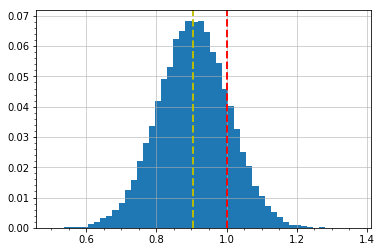

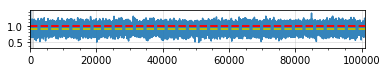

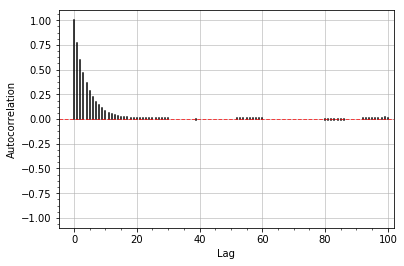

In [68]:
from hypothesis.inference import MetropolisHastings

def log_likelihood(theta, observations):
    with torch.no_grad():
        N = Normal(theta.item(), 1.)
        likelihood = N.log_prob(observations).sum()
        
    return likelihood

sampler = MetropolisHastings(log_likelihood, transition)
result = sampler.infer(observations,
              theta_0=theta_0,
              samples=steps,
              burnin_steps=burnin_steps)

visualize(result)

### Likelihood-free Metropolis Hastings

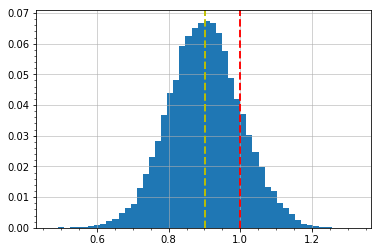

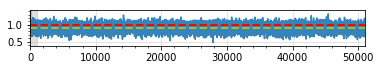

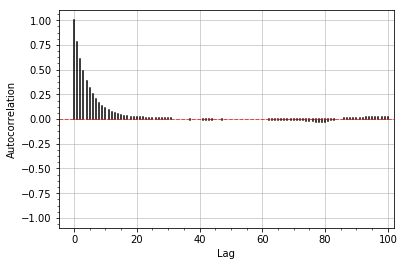

In [65]:
from hypothesis.inference import RatioMetropolisHastings
from hypothesis.util import epsilon

def lfmh(classifier):
    classifier.eval()

    # Define the ratio.
    def ratio(observations, theta_next, theta):
        n = observations.size(0)
        theta_next = theta_next.repeat(n).view(-1, 1)
        theta = theta.repeat(n).view(-1, 1)
        x_in = torch.cat([theta, observations], dim=1)
        x_in_next = torch.cat([theta_next, observations], dim=1)
        s = classifier(x_in)
        s_next = classifier(x_in_next)
        lr = (s / (1 - s + epsilon)).log().sum()
        lr_next = (s_next / (1 - s_next + epsilon)).log().sum()
        lr = (lr_next - lr).exp().item()

        return lr

    # Apply the sampler.
    sampler = RatioMetropolisHastings(ratio, transition)
    result = sampler.infer(observations,
                  theta_0=theta_0,
                  samples=steps,
                  burnin_steps=burnin_steps)
    # Visualize the result.
    visualize(result)
    
lfmh(classifier)

## Influence of network capacity on the posterior

In [57]:
capacities = [50, 100, 200, 250, 500, 1000, 2000]